# Import Libraries

In [ ]:
# Import Libraries
import os
import re
import time
import json
import nltk
import torch
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)
import math
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import DataParallel
import torch.optim as optim
from tqdm import tqdm
from transformers import GPT2Model, GPT2Config
import seaborn as sns
import matplotlib.pyplot as plt
from rouge import Rouge
from copy import deepcopy


# Model Configuration

In [ ]:
class Args():
    def __init__(self):
        # load train dataset
        self.dataset_dir = r"D:\KatzBot\katzbot"
        
        
        self.train_path = r"dataset_katzbot/New_Train_QA_Pairs.csv"
        self.input_file_path = os.path.join(self.dataset_dir, self.train_path)
        
        # load test dataset
        self.test_path = r"dataset_katzbot/Test_QA_Pairs.csv"
        self.test_data = os.path.join(self.dataset_dir, self.test_path)
        self.save_text_file = "predicted_answer.txt"
        self.predict_file = "Test_QA_Pairs_pretrained_gpt.csv"
        
        self.original_text = "answer"
        self.predicted_result = "predicted_answer"

        
        # list of gpt model 
        self.gpt = "gpt2"
        # # Model and tokeniser
        self.model_type = self.gpt
        self.tokenizer_name = self.gpt
        
        # Sets the directory to which the trained model will be saved
        self.output_dir_sent = 'models_custom_sentence'
        self.output_dir = 'models_custom_qa'
        self.model_name = "custom_gpt2.pt"
        
        # Parameters
        # Set the seed value all over the place to make this reproducible.
        self.seed_val = 42
        self.batch_size = 4
        self.epochs = 100
        self.learning_rate = 5e-4
        self.warmup_steps = 1e1
        self.epsilon = 1e-5
        self.weight_decay = 1e-2
        self.sample_every = 100
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
args = Args()


In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = args.seed_val

# Set the random seed for the Python built-in `random` module.
random.seed(seed_val)
np.random.seed(seed_val)

# Set the random seed for PyTorch to ensure reproducibility on the GPU.
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


# Custom Model

In [ ]:
class CustomGPT2LMHeadModel(nn.Module):
    def __init__(self, config, num_extra_blocks=0, num_extra_attentions=0):
        super().__init__()
        self.config = config  # Store the configuration passed to the model
        self.gpt2 = GPT2Model(config)  

        # Add additional MultiheadAttention layers as specified by num_extra_attentions
        self.extra_attentions = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=config.n_embd, num_heads=config.num_attention_heads)
            for _ in range(num_extra_attentions)
        ])

        # Clone the first block from GPT2 multiple times as specified by num_extra_blocks
        self.extra_blocks = nn.ModuleList([deepcopy(self.gpt2.h[0]) for _ in range(num_extra_blocks)])
        
        # Linear layer for converting hidden states to vocabulary size (output layer)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # Ensure the input and output embeddings share weights
        self.tie_weights()  
        self.device = torch.device("cuda") 
         
    def tie_weights(self):
        """ Tie the weights between the input embeddings and the output logits. """
        self.lm_head.weight = nn.Parameter(self.gpt2.wte.weight.clone())

    def resize_token_embeddings(self, new_num_tokens):
        """ Resize the token embeddings in the model to accommodate new vocabulary size. """
        old_embeddings = self.gpt2.wte
        new_embeddings = nn.Embedding(new_num_tokens, old_embeddings.embedding_dim)
        new_embeddings.to(old_embeddings.weight.device)

        # Copy weights from old embeddings to new one for the overlapped part
        num_tokens_to_copy = min(new_num_tokens, old_embeddings.num_embeddings)
        new_embeddings.weight.data[:num_tokens_to_copy, :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

        # Update embeddings in model
        self.gpt2.wte = new_embeddings
        self.tie_weights()  # Re-tie weights after resizing embeddings

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Process input through the main GPT-2 model
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        # Handle the attention mask for additional attention layers
        if attention_mask is not None:
            attention_mask = attention_mask.bool()
            key_padding_mask = ~attention_mask  # Invert the attention mask for masking in MultiheadAttention
        else:
            key_padding_mask = None

        # Apply extra attention layers before processing through the GPT-2 blocks
        for attention in self.extra_attentions:
            sequence_output = sequence_output.transpose(0, 1)  # Transpose for attention input
            attn_output, _ = attention(sequence_output, sequence_output, sequence_output, key_padding_mask=key_padding_mask)
            sequence_output = attn_output.transpose(0, 1)  # Transpose back

        # Process output through additional GPT-2 blocks
        for block in self.extra_blocks:
            layer_outputs = block(sequence_output, attention_mask=outputs.attentions)
            sequence_output = layer_outputs[0]  # Only take the output, not the attention scores

        # Calculate logits using the output layer
        logits = self.lm_head(sequence_output)

        loss = None
        if labels is not None:
            # Calculate loss if labels are provided
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return (loss, logits) if loss is not None else logits
    
    def generate(self, generated, max_length=512, do_sample=True, top_k=50, top_p=0.95, num_return_sequences=1, pad_token_id=None, eos_token_id=None):
        self.eval()  # Set the model to eval mode for generation
        generated_sequences = []

        with torch.no_grad():
            for _ in range(num_return_sequences):
                # # Start with bos token
                # input_ids = torch.tensor([bos_token_id], device=self.device).unsqueeze(0)
                # generated = input_ids

                for _ in range(max_length):
                    outputs = self(generated, attention_mask=None)  # No need for labels or attention mask here
                    logits = outputs[1] if isinstance(outputs, tuple) else outputs
                    logits = logits[:, -1, :]  # Get the logits for the last token produced

                    # Apply top-k and top-p filtering
                    filtered_logits = top_k_top_p_filtering(logits.squeeze(0), top_k=top_k, top_p=top_p)
                    probabilities = F.softmax(filtered_logits, dim=-1)
                    
                    # Sample from the filtered distribution
                    next_token_id = torch.multinomial(probabilities, 1).unsqueeze(0)

                    # Check for eos_token_id
                    if next_token_id == eos_token_id:
                        break

                    # Append generated token ID to generated sequence
                    generated = torch.cat((generated, next_token_id), dim=1)

                generated_sequences.append(generated)

        return generated_sequences
    
    
    def save_pretrained(self, save_directory):
        os.makedirs(save_directory, exist_ok=True)
        model_to_save = self.module if hasattr(self, 'module') else self
        torch.save(model_to_save.state_dict(), os.path.join(save_directory, 'pytorch_model.bin'))
        with open(os.path.join(save_directory, 'config.json'), 'w') as f:
            json.dump(self.config.__dict__, f)


def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value

    return logits



In [ ]:
# Load the question-answer dataset
df = pd.read_csv(args.input_file_path)

# Add marks for original promp and repsonse marks
df['question'] = '[WP]' + df['question'] 
df['answer'] = '\n[RESPONSE]' + df['answer']

# merge just question and answer into one
howtos = df["question"] + df["answer"] 

# clean up by removing certain characters or patterns that may cause issues downstream
howtos.str.replace('"', '').str.replace('\n,\n', '').str.replace('``', '').str.replace(',,', ',')


# Load the GPT tokenizer and add special tokens.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yzhang21\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 2000x1000 with 0 Axes>

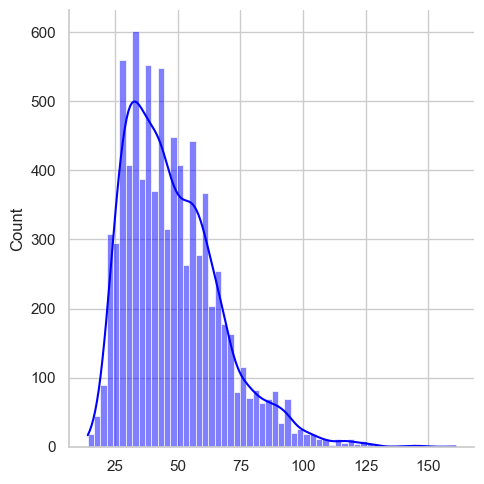

In [ ]:
nltk.download('punkt')
# check distribution of the answers' length
doc_lengths = []  

for howto in howtos: 
    # Tokenize the "howto" text into individual words and get the length of the tokenized text
    tokens = nltk.word_tokenize(howto)
    doc_lengths.append(len(tokens))  
    
# Convert the list of lengths into a NumPy array for easier manipulation
doc_lengths = np.array(doc_lengths)  
plt.figure(figsize=(20, 10))  
# Set the style of the seaborn plots to "whitegrid"
sns.set(style="whitegrid")  

# Plot the distribution of document lengths using a histogram (displot) with a kernel density estimate (kde)
sns.displot(doc_lengths, color="blue", kde=True)

# Display the plot
plt.show()

# Custom Dataset

In [ ]:
# Defining a PyTorch dataset class called GPT2Dataset that prepares text data for use with a GPT-2 language model
class GPT2Dataset(Dataset):
    # Define the class constructor method
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=512):
        
        # Store the tokenizer and initialize the input_ids and attn_masks lists
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        # Iterate through each text sample in txt_list
        for txt in txt_list:
            
            # Tokenize the text sample using the tokenizer and truncate it if necessary
            text = txt
            encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            
            # Add the tokenized input and attention mask to their respective lists
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            
    # Define the __len__ method, which returns the number of input samples in the dataset
    def __len__(self):
        return len(self.input_ids)
    
    # Define the __getitem__ method, which returns the input sample and corresponding attention mask at a given index
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 


In [ ]:
dataset = GPT2Dataset(howtos, tokenizer, max_length=512)

# Split the dataset into training and validation sets with a 80/20 split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Create a PyTorch DataLoader instance for the training set 
train_dataloader = DataLoader(
            train_dataset,  # The training dataset
            sampler = RandomSampler(train_dataset), # Randomly sample elements from the training dataset
            batch_size = args.batch_size # The number of samples per batch to load
        )

# Create a PyTorch DataLoader instance for the validation set
validation_dataloader = DataLoader(
            val_dataset, # The validation dataset
            sampler = SequentialSampler(val_dataset), # Iterate through the validation dataset sequentially
            batch_size = args.batch_size # The number of samples per batch to load
        )


# Model Initialization

In [ ]:
# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(args.output_dir_sent)

# Load the trained model

model_config = GPT2Config.from_pretrained('gpt2', vocab_size=len(tokenizer))
model = CustomGPT2LMHeadModel(model_config)

# Resize the model's token embeddings to match the size of the tokenizer's vocabulary
# This step is necessary if any special tokens have been added to the tokenizer
model.resize_token_embeddings(len(tokenizer))

# pytorch to run this model on the GPU.
device = args.device

# Move model to available device
model = model.to(device)

# Check if multiple GPUs are available
if torch.cuda.device_count() > 0:
    # Wrap the model with DataParallel
    model = DataParallel(model)



optimizer = optim.AdamW(model.parameters(),
                        lr=args.learning_rate,
                        eps=args.epsilon,
                       weight_decay = args.weight_decay)

# Calculate the total number of training steps.
# This is the number of batches in the training data multiplied by the number of epochs.
total_steps = len(train_dataloader) * args.epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = args.warmup_steps, 
                                            num_training_steps = total_steps)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# Release all unused memory that is held by the GPU memory cache
torch.cuda.empty_cache()

total_t0 = time.time()

training_stats = []



In [ ]:
# If the directory does not exist, it is created
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

In [ ]:
# Clear the GPU memory cache to free up memory
torch.cuda.empty_cache()
# Display a summary of GPU memory usage
memory_summary = torch.cuda.memory_summary(device=None, abbreviated=False)
# Print the memory summary
print(memory_summary)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 650720 KiB | 650720 KiB | 650720 KiB |      0 B   |
|       from large pool | 637952 KiB | 637952 KiB | 637952 KiB |      0 B   |
|       from small pool |  12768 KiB |  12768 KiB |  12768 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         | 650720 KiB | 650720 KiB | 650720 KiB |      0 B   |
|       from large pool | 637952 KiB | 637952 KiB | 637952 KiB |

In [ ]:
# Variables to track best model
best_training_loss = float('inf')
best_model_path = None

# Use tqdm to display progress over epochs
for epoch_i in range(0, args.epochs):

    # ========================================
    #               Training
    # ========================================
    # Record the start time of the epoch.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()
    
    train_iterator = tqdm(train_dataloader, 
                                      desc=f"Epoch {epoch_i + 1}/{args.epochs} - Training", 
                                      unit="batch")


    # Loop over each batch of training data.
    for step, batch in enumerate(train_iterator): 

        # Clear the GPU memory cache to free up memory
        torch.cuda.empty_cache()

        # Get the input IDs, attention masks, and labels for this batch,
        # and move them to the GPU if necessary.
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        # Zero out any gradients that have accumulated from previous batches.
        model.zero_grad()        

        # Run this batch through the model to get the loss.
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                        #   token_type_ids=None
                        )

        loss = outputs[0] 

        # If using DataParallel, average the loss across all GPUs
        if isinstance(model, torch.nn.DataParallel) and loss is not None:
            loss = loss.mean()

        # Get the loss for this batch, and add it to the total loss for this epoch.
        if loss is not None:
            batch_loss = loss.item()
            total_train_loss += batch_loss

        # Print some generated output every `sample_every` batches.
        if step % args.sample_every == 0 and not step == 0:
            
            # Measure how long this has taken so far.
            elapsed = format_time(time.time() - t0)

            # Put the model into evaluation mode.
            model.eval()

            # Generate some sample output from the model.
            sample_outputs = model.module.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 512,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    pad_token_id=tokenizer.eos_token_id,
                                    eos_token_id=-1,
                                )
            # Put the model back into training mode.
            model.train()
        train_iterator.set_postfix(loss=batch_loss)

        # Backpropagate the loss and update the model parameters.
        if loss is not None:
            loss.backward()
            optimizer.step()

            # Update the learning rate scheduler.
            scheduler.step()

    # Calculate the average loss over all of the batches.
    if total_train_loss > 0:
        avg_train_loss = total_train_loss / len(train_dataloader)
    else:
        avg_train_loss = 0
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
     

    # ========================================
    #               Validation
    # ========================================
    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    val_iterator = tqdm(validation_dataloader, 
                        desc=f"Epoch {epoch_i + 1}/{args.epochs} - Validation", 
                        unit="batch")

    # Evaluate data for one epoch
    for val_step, batch in enumerate(val_iterator):
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        
            # Run this batch through the model to get the loss.
            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
            
            loss = outputs[0] 
          
        # If using DataParallel, average the loss across all GPUs
        if isinstance(model, torch.nn.DataParallel) and loss is not None:
            loss = loss.mean()

        # Get the loss for this batch, and add it to the total loss for this epoch.
        if loss is not None:
            total_eval_loss += loss.item()

        val_iterator.set_postfix(loss=total_eval_loss / (val_step + 1))   

    avg_val_loss = total_eval_loss / len(validation_dataloader) if len(validation_dataloader) > 0 else 0

    
    validation_time = format_time(time.time() - t0)   
    
    print(f"Average loss => Training: {avg_train_loss:.2f} | Validation: {avg_val_loss:.2f}") 

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    # Update best model if training loss improves
    if avg_train_loss < best_training_loss:
        best_training_loss = avg_train_loss 
        # best_model_path = os.path.join(output_dir, model_name)
        
        # This line ensures that the correct model is saved even if the code is running in a distributed/parallel environment
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training

        model_to_save.save_pretrained(args.output_dir)
        
        torch.save(model.state_dict(), os.path.join(args.output_dir, args.model_name))
        tokenizer.save_pretrained(args.output_dir)
        print("Model Saved")
    print("\n")

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Epoch 1/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.39batch/s, loss=0.593]


Average loss => Training: 0.86 | Validation: 0.59
Model Saved




Epoch 2/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.01batch/s, loss=0.531]


Average loss => Training: 0.57 | Validation: 0.53
Model Saved




Epoch 3/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.08batch/s, loss=0.472]


Average loss => Training: 0.50 | Validation: 0.47
Model Saved




Epoch 4/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.07batch/s, loss=0.421]


Average loss => Training: 0.43 | Validation: 0.42
Model Saved




Epoch 5/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.11batch/s, loss=0.399]


Average loss => Training: 0.39 | Validation: 0.40
Model Saved




Epoch 6/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.06batch/s, loss=0.38] 


Average loss => Training: 0.35 | Validation: 0.38
Model Saved




Epoch 7/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.06batch/s, loss=0.365]


Average loss => Training: 0.32 | Validation: 0.36
Model Saved




Epoch 8/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.09batch/s, loss=0.355]


Average loss => Training: 0.29 | Validation: 0.35
Model Saved




Epoch 9/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.04batch/s, loss=0.345]


Average loss => Training: 0.26 | Validation: 0.35
Model Saved




Epoch 10/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.02batch/s, loss=0.341]


Average loss => Training: 0.24 | Validation: 0.34
Model Saved




Epoch 11/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.17batch/s, loss=0.339]


Average loss => Training: 0.22 | Validation: 0.34
Model Saved




Epoch 12/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.13batch/s, loss=0.339]


Average loss => Training: 0.19 | Validation: 0.34
Model Saved




Epoch 13/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 18.99batch/s, loss=0.342]


Average loss => Training: 0.18 | Validation: 0.34
Model Saved




Epoch 14/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.03batch/s, loss=0.344]


Average loss => Training: 0.16 | Validation: 0.34
Model Saved




Epoch 15/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.06batch/s, loss=0.348]


Average loss => Training: 0.14 | Validation: 0.35
Model Saved




Epoch 16/100 - Validation: 100%|██████████| 417/417 [00:21<00:00, 19.07batch/s, loss=0.354]


Average loss => Training: 0.12 | Validation: 0.35
Model Saved




Epoch 17/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.27batch/s, loss=0.359]


Average loss => Training: 0.11 | Validation: 0.36
Model Saved




Epoch 18/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.23batch/s, loss=0.369]


Average loss => Training: 0.10 | Validation: 0.37
Model Saved




Epoch 19/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.25batch/s, loss=0.374]


Average loss => Training: 0.09 | Validation: 0.37
Model Saved




Epoch 20/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.32batch/s, loss=0.381]


Average loss => Training: 0.08 | Validation: 0.38
Model Saved




Epoch 21/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.31batch/s, loss=0.389]


Average loss => Training: 0.07 | Validation: 0.39
Model Saved




Epoch 22/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.29batch/s, loss=0.398]


Average loss => Training: 0.06 | Validation: 0.40
Model Saved




Epoch 23/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.25batch/s, loss=0.403]


Average loss => Training: 0.06 | Validation: 0.40
Model Saved




Epoch 24/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.42batch/s, loss=0.407]


Average loss => Training: 0.05 | Validation: 0.41
Model Saved




Epoch 25/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.36batch/s, loss=0.415]


Average loss => Training: 0.05 | Validation: 0.41
Model Saved




Epoch 26/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.25batch/s, loss=0.419]


Average loss => Training: 0.05 | Validation: 0.42
Model Saved




Epoch 27/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.27batch/s, loss=0.424]


Average loss => Training: 0.04 | Validation: 0.42
Model Saved




Epoch 28/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.21batch/s, loss=0.427]


Average loss => Training: 0.04 | Validation: 0.43
Model Saved




Epoch 29/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.40batch/s, loss=0.432]


Average loss => Training: 0.04 | Validation: 0.43
Model Saved




Epoch 30/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.33batch/s, loss=0.435]


Average loss => Training: 0.04 | Validation: 0.44
Model Saved




Epoch 31/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.43batch/s, loss=0.435]


Average loss => Training: 0.04 | Validation: 0.43
Model Saved




Epoch 32/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.45batch/s, loss=0.44] 


Average loss => Training: 0.03 | Validation: 0.44
Model Saved




Epoch 33/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.42batch/s, loss=0.441]


Average loss => Training: 0.03 | Validation: 0.44
Model Saved




Epoch 34/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.45batch/s, loss=0.442]


Average loss => Training: 0.03 | Validation: 0.44
Model Saved




Epoch 35/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.28batch/s, loss=0.447]


Average loss => Training: 0.03 | Validation: 0.45
Model Saved




Epoch 36/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.31batch/s, loss=0.448]


Average loss => Training: 0.03 | Validation: 0.45
Model Saved




Epoch 37/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.71batch/s, loss=0.446]


Average loss => Training: 0.03 | Validation: 0.45
Model Saved




Epoch 38/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.72batch/s, loss=0.45] 


Average loss => Training: 0.03 | Validation: 0.45
Model Saved




Epoch 39/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.80batch/s, loss=0.452]


Average loss => Training: 0.03 | Validation: 0.45
Model Saved




Epoch 40/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.76batch/s, loss=0.453]


Average loss => Training: 0.03 | Validation: 0.45
Model Saved




Epoch 41/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.67batch/s, loss=0.456]


Average loss => Training: 0.03 | Validation: 0.46
Model Saved




Epoch 42/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.64batch/s, loss=0.454]


Average loss => Training: 0.03 | Validation: 0.45
Model Saved




Epoch 43/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.21batch/s, loss=0.456]


Average loss => Training: 0.03 | Validation: 0.46
Model Saved




Epoch 44/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.36batch/s, loss=0.457]


Average loss => Training: 0.03 | Validation: 0.46
Model Saved




Epoch 45/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.46batch/s, loss=0.454]


Average loss => Training: 0.03 | Validation: 0.45
Model Saved




Epoch 46/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.26batch/s, loss=0.457]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 47/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.10batch/s, loss=0.461]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 48/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.23batch/s, loss=0.461]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 49/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.16batch/s, loss=0.463]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 50/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.38batch/s, loss=0.463]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 51/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.14batch/s, loss=0.462]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 52/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.06batch/s, loss=0.467]


Average loss => Training: 0.02 | Validation: 0.47
Model Saved




Epoch 53/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.05batch/s, loss=0.464]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 54/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.37batch/s, loss=0.461]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 55/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.78batch/s, loss=0.462]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 56/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.69batch/s, loss=0.463]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 57/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.73batch/s, loss=0.464]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 58/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.67batch/s, loss=0.462]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 59/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.69batch/s, loss=0.462]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 60/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.70batch/s, loss=0.463]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 61/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.76batch/s, loss=0.463]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 62/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.72batch/s, loss=0.463]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 63/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.67batch/s, loss=0.467]


Average loss => Training: 0.02 | Validation: 0.47
Model Saved




Epoch 64/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.66batch/s, loss=0.466]


Average loss => Training: 0.02 | Validation: 0.47
Model Saved




Epoch 65/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.92batch/s, loss=0.464]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 66/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.70batch/s, loss=0.464]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 67/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.35batch/s, loss=0.464]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 68/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.31batch/s, loss=0.464]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 69/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.49batch/s, loss=0.463]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 70/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.46batch/s, loss=0.461]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 71/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.27batch/s, loss=0.461]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 72/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.24batch/s, loss=0.462]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 73/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.47batch/s, loss=0.461]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 74/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.48batch/s, loss=0.46] 


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 75/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.80batch/s, loss=0.461]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 76/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.73batch/s, loss=0.458]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 77/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.34batch/s, loss=0.46] 


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 78/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.22batch/s, loss=0.457]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 79/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.37batch/s, loss=0.458]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 80/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.56batch/s, loss=0.457]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 81/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.53batch/s, loss=0.458]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 82/100 - Validation: 100%|██████████| 417/417 [00:25<00:00, 16.54batch/s, loss=0.458]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 83/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.24batch/s, loss=0.458]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 84/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.21batch/s, loss=0.457]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 85/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.79batch/s, loss=0.457]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 86/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.69batch/s, loss=0.455]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 87/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.72batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 88/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.70batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 89/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.27batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 90/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.25batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 91/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.31batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 92/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.50batch/s, loss=0.455]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 93/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.49batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 94/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.52batch/s, loss=0.455]


Average loss => Training: 0.02 | Validation: 0.45
Model Saved




Epoch 95/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.61batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 96/100 - Validation: 100%|██████████| 417/417 [00:23<00:00, 17.51batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 97/100 - Validation: 100%|██████████| 417/417 [00:24<00:00, 17.14batch/s, loss=0.456]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 98/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.65batch/s, loss=0.457]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 99/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.66batch/s, loss=0.457]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved




Epoch 100/100 - Validation: 100%|██████████| 417/417 [00:22<00:00, 18.71batch/s, loss=0.457]


Average loss => Training: 0.02 | Validation: 0.46
Model Saved



Training complete!
Total training took 17:41:32 (h:mm:ss)


In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.864956,0.592991,0:09:10,0:00:22
2,0.570549,0.530607,0:09:08,0:00:22
3,0.497314,0.472090,0:09:06,0:00:22
4,0.432855,0.420732,0:09:07,0:00:22
5,0.388082,0.399043,0:09:04,0:00:22
...,...,...,...,...
96,0.018025,0.456091,0:09:53,0:00:24
97,0.017923,0.456495,0:09:59,0:00:24
98,0.017873,0.456675,0:09:32,0:00:22


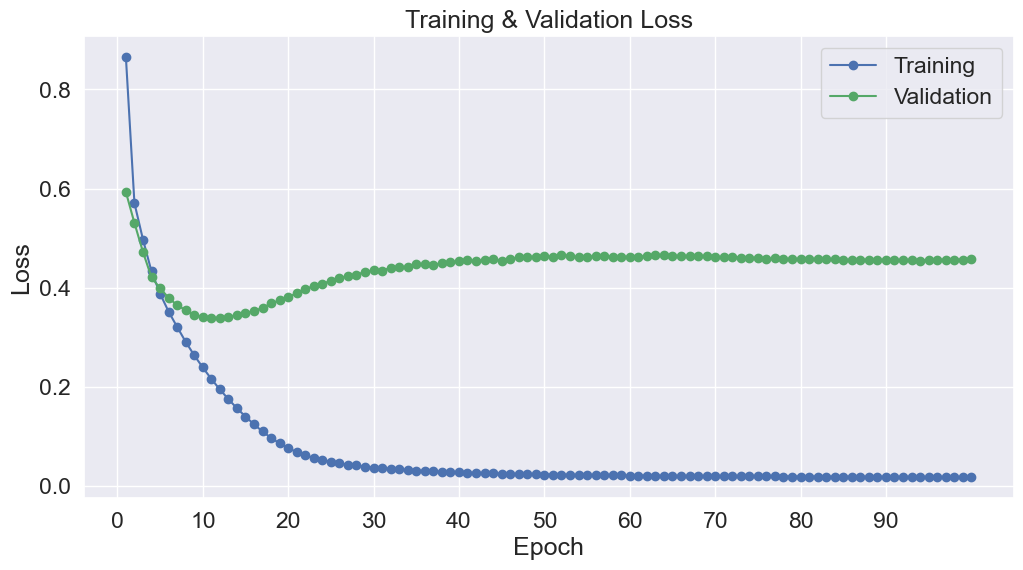

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Set the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks for the length of epochs
num_epochs = len(df_stats)
plt.xticks(range(0, num_epochs, 10))

plt.show()


In [ ]:
# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(args.output_dir)

# Load the trained model
model_config = GPT2Config.from_pretrained('gpt2', vocab_size=len(tokenizer))
model = CustomGPT2LMHeadModel(model_config)
model.load_state_dict(torch.load(os.path.join(args.output_dir, args.model_name)))


# Move the model to the appropriate device (GPU if available, otherwise CPU)
model = model.to(device)

In [ ]:
test_df = pd.read_csv(args.test_data)

In [ ]:
# Generates the answer for the data test.
model.eval()
def generate_ans(question: str):
    responses = []
    input_prompt = question
    prompt = f"\n<|startoftext|>[WP] {input_prompt} \n[RESPONSE]"

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = model.generate(
                                    generated, 
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 512,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                    )
    
    for i, sample_output in enumerate(sample_outputs):
        # Flatten the tensor if necessary
        if sample_output.dim() > 1:
            sample_output = sample_output.squeeze()
        
        # Decode to text
        response_text = tokenizer.decode(sample_output.tolist(), skip_special_tokens=True)
        
        # Split based on your markers
        wp_responses = re.split(r"\[WP\].*?\n|\[RESPONSE\]", response_text)[1:]
    return wp_responses[1].strip() if wp_responses else "No response found"

In [ ]:
text_file = os.path.join(args.output_dir, args.save_text_file)
answers1 = []


with open(text_file, 'w') as f:
    for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
        question, answer = row
        answer_gpt = generate_ans(question)
        answers1.append(answer_gpt)

        f.write(f"Question {i+1}/{len(test_df)} => {question}\n")
        f.write(f"Answer => {answer}\n")
        f.write(f"Predicted Answer => {answer_gpt}\n")
        f.write('\n\n')

# Optionally, you can print a message indicating that the output has been saved
print(f"Output saved to {text_file}")

  0%|          | 0/2081 [00:00<?, ?it/s]

100%|██████████| 2081/2081 [4:27:20<00:00,  7.71s/it]  

Output saved to models_custom_1\predicted_answer.txt


In [ ]:
def calculate_rouge_scores(preds, original_text_col, predicted_result_col):
    rouge_scores = []
    hyps = []  # list of predicted answers
    refs = []  # list of reference answers

    for index, row in preds.iterrows():
        act_ans = str(row[original_text_col])
        pred_ans = str(row[predicted_result_col])

        hyps.append(pred_ans)
        refs.append(act_ans)

    rouge = Rouge()
    scores = rouge.get_scores(hyps, refs, avg=True)
    rouge_scores.append(scores)

    # Create a list of dictionaries for tabulating the scores
    score_table = [{'Metric': metric, 'Precision': score['p'], 'Recall': score['r'], 'F1-Score': score['f']} for metric, score in scores.items()]
    metrics_df = pd.DataFrame(score_table)
    
    return metrics_df

In [ ]:
# Add the predicted answers as a new column in the dataframe
test_df[args.predicted_result] = answers1

test_predict = os.path.join(args.output_dir, args.predict_file)

# Save the updated dataframe to a new CSV file
test_df.to_csv(test_predict, index=False)

print(len(answers1))
# Load the QApairs.csv file into a pandas dataframe
preds = pd.read_csv(test_predict)

In [ ]:
# Add the predicted answers as a new column in the dataframe
test_df[args.predicted_result] = answers1

test_predict = os.path.join(args.output_dir, args.predict_file)

# Save the updated dataframe to a new CSV file
test_df.to_csv(test_predict, index=False)

In [ ]:
metrics_df = calculate_rouge_scores(preds, args.original_text, args.predicted_result)
metrics_df

,Metric,Precision,Recall,F1-Score
0,rouge-1,0.600745,0.502953,0.528094
1,rouge-2,0.469578,0.412039,0.424645
2,rouge-l,0.584838,0.492629,0.516065
